### Homework 7
Damion Huppert

##### Question 1-a

In [1]:
# %pip install torch torchvision torchaudio

import torch
import torch.nn.functional as F

A = torch.tensor([
    [9, 4, 5],
    [3, 6, 8],
    [8, 1, 9]
], dtype=torch.float32)

B = (1/8) * torch.tensor([
    [0, 1, 0],
    [1, 4, 1],
    [0, 1, 0]
], dtype=torch.float32)

A = A.unsqueeze(0).unsqueeze(0)  # Shape: (batch_size=1, channels=1, height=3, width=3)
B = B.unsqueeze(0).unsqueeze(0)  # Shape: (out_channels=1, in_channels=1, height=3, width=3)

# Perform convolution
output = F.conv2d(A, B, stride=2, padding=1)

# Print result
print(output.squeeze(0).squeeze(0))


tensor([[5.3750, 4.0000],
        [4.5000, 5.6250]])


##### Question 2-a

In [2]:
import torchvision.datasets as db
train_dataset = db . FashionMNIST(root="./", train = True , download = True )
test_dataset = db . FashionMNIST( root="./" , train = False , download = True)

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\damio\appdata\local\programs\python\python311\lib\site-packages (3.10.1)




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


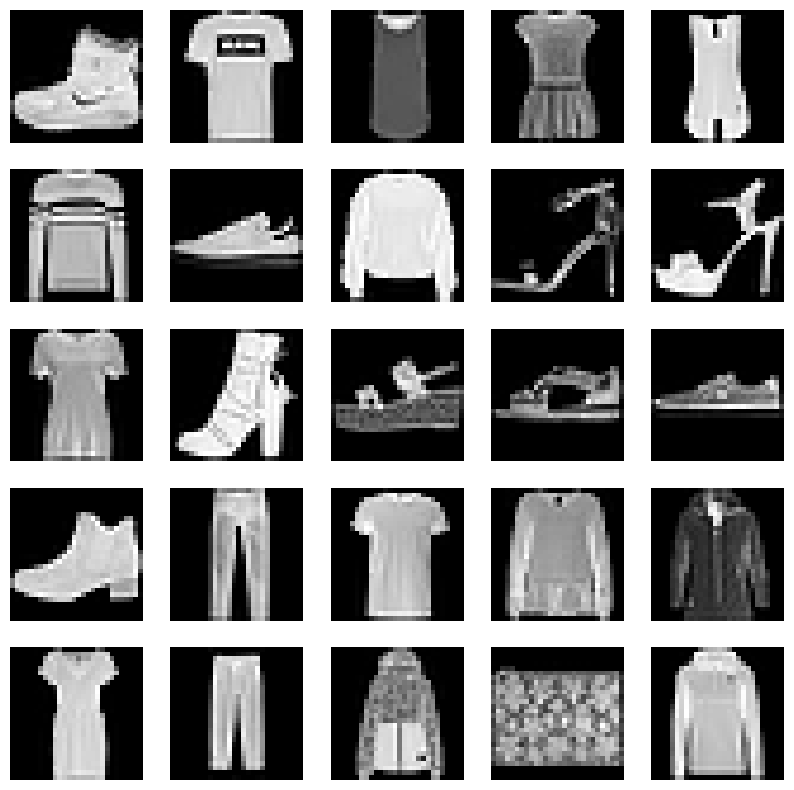

In [3]:
%pip install matplotlib
%pip install numpy


import matplotlib.pyplot as plt
# Plot first 25 images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset.data[i], cmap='gray')
    ax.axis('off')
plt.show()

In [4]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [5]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

##### Question 2-b

In [6]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

    nn.Flatten(),

    nn.Linear(32 * 7 * 7, 10),
    nn.Softmax(dim=1)
)

print(model)


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=10, bias=True)
  (8): Softmax(dim=1)
)


##### Question 2-c

In [13]:
%pip install tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import tqdm
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as db
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset setup
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = db.FashionMNIST(root="./", train=True, download=True, transform=transform)
test_dataset = db.FashionMNIST(root="./", train=False, download=True, transform=transform)

# DataLoader
loader_train = DataLoader(train_dataset, batch_size=1024, shuffle=True, drop_last=True)
loader_test = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Model setup
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(32 * 7 * 7, 10),
    nn.Softmax(dim=1)
)

# Move model to GPU
model = model.to(device)

# Weight Initialization
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.001)

# Loss and Optimizer
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()
    
        l.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)

def fit(model, loader_train, loader_test, epochs=50):
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)
        
        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

# Initialize weights and train
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Using device: cuda


100%|██████████| 10/10 [00:00<00:00, 11.29it/s]

Finished epoch 0 of 50: Train Loss = 2.274   Train Acc = 0.145   Test Acc = 0.313



100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

Finished epoch 1 of 50: Train Loss = 1.912   Train Acc = 0.593   Test Acc = 0.697



100%|██████████| 10/10 [00:00<00:00, 12.78it/s]

Finished epoch 2 of 50: Train Loss = 1.762   Train Acc = 0.717   Test Acc = 0.726



100%|██████████| 10/10 [00:00<00:00, 12.75it/s]

Finished epoch 3 of 50: Train Loss = 1.733   Train Acc = 0.738   Test Acc = 0.740



100%|██████████| 10/10 [00:00<00:00, 12.75it/s]

Finished epoch 4 of 50: Train Loss = 1.718   Train Acc = 0.750   Test Acc = 0.751



100%|██████████| 10/10 [00:00<00:00, 12.91it/s]

Finished epoch 5 of 50: Train Loss = 1.710   Train Acc = 0.757   Test Acc = 0.755



100%|██████████| 10/10 [00:00<00:00, 12.27it/s]

Finished epoch 6 of 50: Train Loss = 1.703   Train Acc = 0.762   Test Acc = 0.756



100%|██████████| 10/10 [00:00<00:00, 12.81it/s]

Finished epoch 7 of 50: Train Loss = 1.699   Train Acc = 0.766   Test Acc = 0.763



100%|██████████| 10/10 [00:00<00:00, 12.63it/s]

Finished epoch 8 of 50: Train Loss = 1.695   Train Acc = 0.769   Test Acc = 0.759



100%|██████████| 10/10 [00:00<00:00, 12.90it/s]

Finished epoch 9 of 50: Train Loss = 1.694   Train Acc = 0.770   Test Acc = 0.768



100%|██████████| 10/10 [00:00<00:00, 12.97it/s]

Finished epoch 10 of 50: Train Loss = 1.691   Train Acc = 0.773   Test Acc = 0.769



100%|██████████| 10/10 [00:00<00:00, 12.46it/s]

Finished epoch 11 of 50: Train Loss = 1.687   Train Acc = 0.776   Test Acc = 0.772



100%|██████████| 10/10 [00:00<00:00, 11.08it/s]

Finished epoch 12 of 50: Train Loss = 1.684   Train Acc = 0.779   Test Acc = 0.774



100%|██████████| 10/10 [00:00<00:00, 12.06it/s]

Finished epoch 13 of 50: Train Loss = 1.682   Train Acc = 0.782   Test Acc = 0.777



100%|██████████| 10/10 [00:00<00:00, 13.11it/s]

Finished epoch 14 of 50: Train Loss = 1.680   Train Acc = 0.784   Test Acc = 0.775



100%|██████████| 10/10 [00:00<00:00, 12.86it/s]

Finished epoch 15 of 50: Train Loss = 1.677   Train Acc = 0.786   Test Acc = 0.781



100%|██████████| 10/10 [00:00<00:00, 12.88it/s]

Finished epoch 16 of 50: Train Loss = 1.676   Train Acc = 0.787   Test Acc = 0.780



100%|██████████| 10/10 [00:00<00:00, 13.39it/s]

Finished epoch 17 of 50: Train Loss = 1.675   Train Acc = 0.787   Test Acc = 0.782



100%|██████████| 10/10 [00:00<00:00, 12.59it/s]

Finished epoch 18 of 50: Train Loss = 1.673   Train Acc = 0.790   Test Acc = 0.785



100%|██████████| 10/10 [00:00<00:00, 12.16it/s]

Finished epoch 19 of 50: Train Loss = 1.671   Train Acc = 0.791   Test Acc = 0.787



100%|██████████| 10/10 [00:00<00:00, 12.06it/s]

Finished epoch 20 of 50: Train Loss = 1.669   Train Acc = 0.793   Test Acc = 0.787



100%|██████████| 10/10 [00:00<00:00, 11.92it/s]

Finished epoch 21 of 50: Train Loss = 1.669   Train Acc = 0.794   Test Acc = 0.787



100%|██████████| 10/10 [00:00<00:00, 12.51it/s]

Finished epoch 22 of 50: Train Loss = 1.667   Train Acc = 0.796   Test Acc = 0.790



100%|██████████| 10/10 [00:00<00:00, 12.73it/s]

Finished epoch 23 of 50: Train Loss = 1.665   Train Acc = 0.797   Test Acc = 0.791



100%|██████████| 10/10 [00:00<00:00, 13.37it/s]

Finished epoch 24 of 50: Train Loss = 1.665   Train Acc = 0.798   Test Acc = 0.790



100%|██████████| 10/10 [00:00<00:00, 13.03it/s]

Finished epoch 25 of 50: Train Loss = 1.663   Train Acc = 0.800   Test Acc = 0.792



100%|██████████| 10/10 [00:00<00:00, 12.61it/s]

Finished epoch 26 of 50: Train Loss = 1.661   Train Acc = 0.801   Test Acc = 0.795



100%|██████████| 10/10 [00:00<00:00, 12.84it/s]

Finished epoch 27 of 50: Train Loss = 1.660   Train Acc = 0.802   Test Acc = 0.791



100%|██████████| 10/10 [00:00<00:00, 12.83it/s]

Finished epoch 28 of 50: Train Loss = 1.659   Train Acc = 0.803   Test Acc = 0.796



100%|██████████| 10/10 [00:00<00:00, 10.73it/s]

Finished epoch 29 of 50: Train Loss = 1.658   Train Acc = 0.805   Test Acc = 0.799



100%|██████████| 10/10 [00:00<00:00, 11.03it/s]

Finished epoch 30 of 50: Train Loss = 1.657   Train Acc = 0.806   Test Acc = 0.797



100%|██████████| 10/10 [00:00<00:00, 11.09it/s]

Finished epoch 31 of 50: Train Loss = 1.655   Train Acc = 0.807   Test Acc = 0.801



100%|██████████| 10/10 [00:00<00:00, 11.84it/s]

Finished epoch 32 of 50: Train Loss = 1.655   Train Acc = 0.807   Test Acc = 0.801



100%|██████████| 10/10 [00:00<00:00, 12.04it/s]

Finished epoch 33 of 50: Train Loss = 1.654   Train Acc = 0.808   Test Acc = 0.803



100%|██████████| 10/10 [00:00<00:00, 12.38it/s]

Finished epoch 34 of 50: Train Loss = 1.652   Train Acc = 0.811   Test Acc = 0.803



100%|██████████| 10/10 [00:00<00:00, 12.27it/s]

Finished epoch 35 of 50: Train Loss = 1.650   Train Acc = 0.812   Test Acc = 0.804



100%|██████████| 10/10 [00:00<00:00, 11.77it/s]

Finished epoch 36 of 50: Train Loss = 1.649   Train Acc = 0.814   Test Acc = 0.805



100%|██████████| 10/10 [00:00<00:00, 12.92it/s]

Finished epoch 37 of 50: Train Loss = 1.650   Train Acc = 0.812   Test Acc = 0.804



100%|██████████| 10/10 [00:00<00:00, 10.12it/s]

Finished epoch 38 of 50: Train Loss = 1.648   Train Acc = 0.815   Test Acc = 0.807



100%|██████████| 10/10 [00:00<00:00, 10.30it/s]

Finished epoch 39 of 50: Train Loss = 1.647   Train Acc = 0.816   Test Acc = 0.808



100%|██████████| 10/10 [00:00<00:00, 12.59it/s]

Finished epoch 40 of 50: Train Loss = 1.646   Train Acc = 0.817   Test Acc = 0.807



100%|██████████| 10/10 [00:01<00:00,  9.90it/s]

Finished epoch 41 of 50: Train Loss = 1.644   Train Acc = 0.818   Test Acc = 0.809



100%|██████████| 10/10 [00:01<00:00, 10.00it/s]

Finished epoch 42 of 50: Train Loss = 1.645   Train Acc = 0.817   Test Acc = 0.811



100%|██████████| 10/10 [00:01<00:00,  9.00it/s]

Finished epoch 43 of 50: Train Loss = 1.643   Train Acc = 0.819   Test Acc = 0.811



100%|██████████| 10/10 [00:00<00:00, 12.26it/s]

Finished epoch 44 of 50: Train Loss = 1.642   Train Acc = 0.820   Test Acc = 0.811



100%|██████████| 10/10 [00:00<00:00, 10.22it/s]

Finished epoch 45 of 50: Train Loss = 1.641   Train Acc = 0.821   Test Acc = 0.812



100%|██████████| 10/10 [00:00<00:00, 12.05it/s]

Finished epoch 46 of 50: Train Loss = 1.640   Train Acc = 0.822   Test Acc = 0.812



100%|██████████| 10/10 [00:00<00:00, 10.35it/s]

Finished epoch 47 of 50: Train Loss = 1.641   Train Acc = 0.821   Test Acc = 0.810



100%|██████████| 10/10 [00:00<00:00, 11.41it/s]

Finished epoch 48 of 50: Train Loss = 1.639   Train Acc = 0.824   Test Acc = 0.813



100%|██████████| 10/10 [00:00<00:00, 12.21it/s]

Finished epoch 49 of 50: Train Loss = 1.639   Train Acc = 0.824   Test Acc = 0.813


In [14]:
@torch.no_grad()
def eval(model, loader):
    correct = torch.zeros(10, device=device)  # Stores correct predictions per class
    total = torch.zeros(10, device=device)  # Stores total samples per class

    for images, labels in tqdm.tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        pred = model(images).argmax(1)  # Get predicted class
        for i in range(10):  # Loop through all 10 classes
            mask = labels == i
            correct[i] += (pred[mask] == i).sum()
            total[i] += mask.sum()

    class_acc = correct / total  # Compute accuracy per class
    class_acc = class_acc.cpu().numpy()  # Convert to NumPy for sorting

    # Get indices of two worst-performing classes
    worst_classes = np.argsort(class_acc)[:2]
    
    print(f"Two worst classes: {worst_classes[0]} ({class_acc[worst_classes[0]]:.3f}), {worst_classes[1]} ({class_acc[worst_classes[1]]:.3f})")
    return class_acc


In [15]:
class_acc = eval(model, loader_test)


100%|██████████| 10/10 [00:00<00:00, 12.42it/s]

Two worst classes: 6 (0.000), 2 (0.773)
